In [2]:

import pandas as pd
import numpy as np
from torchmetrics import MeanSquaredError, MeanAbsoluteError
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, TiDEModel
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss,MAE, RMSE, MAPE, SMAPE
from lightning.pytorch import Trainer
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pytorch_forecasting.models import TimeXer
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.callbacks import EarlyStopping,ModelCheckpoint
from lightning.pytorch.callbacks import Callback
from pytorch_forecasting.models import TimeXer
from pytorch_forecasting.models.nhits import NHiTS




In [3]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
df = pd.read_csv("data/timexer.csv", parse_dates=["date"])
df = df.sort_values("date")
df["time_idx"] = (df["date"] - df["date"].min()).dt.total_seconds().astype(int)
df["series_id"] = 0

In [7]:
num_train = int(len(df) * 0.7)
num_test  = int(len(df) * 0.2)
num_vali  = len(df) - num_train - num_test

In [8]:
train_df = df.iloc[:num_train]
val_df   = df.iloc[num_train : num_train + num_vali]
test_df  = df.iloc[num_train + num_vali :]


In [9]:
max_encoder_length = 50
max_prediction_length = 1
static_categoricals = []
static_reals = []
time_varying_known_reals = [
    "bytes_op0","bytes_op1","bytes_sum","io_count",
    "read_ops_count","write_ops_count",
    "bytes_sum_ema_short","bytes_sum_ema_long",
    "bytes_sum_macd","bytes_sum_macd_signal",
]
time_varying_unknown_reals = ["duration_sum"]
group_ids = ["series_id"]
target = "duration_sum"
batch_size = 64
epochs = 50



In [10]:
covariate_scalers = {
    var: GroupNormalizer(groups=["series_id"]) 
    for var in time_varying_known_reals
}

In [11]:
model_kwargs = dict(
    learning_rate=1e-3,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=128,
    loss=QuantileLoss(quantiles=[0.1,0.5, 0.9]),  
    output_size=3,              # default: QuantileLoss
    logging_metrics=[SMAPE(),MAE(), RMSE(), MAPE()],
    log_interval=10,
    reduce_on_plateau_patience=4,
)


In [75]:
trainer_kwargs = dict(
    max_epochs=epochs,
    accelerator="gpu",
    devices=1,
    gradient_clip_val=0.1,
)

In [76]:
# Horizons to run
horizons = [1, 5, 10, 15, 20]

In [77]:
class PrintLossCallback(Callback):
    def __init__(self, horizon: int):
        super().__init__()
        self.horizon = horizon

    def on_train_epoch_end(self, trainer, pl_module):
        # logged_metrics is updated after validation, so both train_loss and val_loss should be present
        epoch = trainer.current_epoch
        metrics = trainer.callback_metrics
        train_loss = metrics.get("train_loss")
        val_loss   = metrics.get("val_loss")
        print(
            f"Horizon={self.horizon}  "
            f"Epoch={epoch:02d}  "
            f"train_loss={train_loss:.4f}  "
            f"val_loss={val_loss:.4f}"
        )


In [78]:
class PrintLossCallback(Callback):
    def __init__(self, horizon: int):
        super().__init__()
        self.horizon = horizon

    def on_train_epoch_end(self, trainer, pl_module):
        # logged_metrics is updated after validation, so both train_loss and val_loss should be present
        epoch = trainer.current_epoch
        metrics = trainer.callback_metrics
        train_loss = metrics.get("train_loss")
        val_loss   = metrics.get("val_loss")
        print(
            f"Horizon={self.horizon}  "
            f"Epoch={epoch:02d}  "
            f"train_loss={train_loss:.4f}  "
            f"val_loss={val_loss:.4f}"
        )

for horizon in horizons:
    print(f"\nTraining for horizon={horizon}")
    ckpt_dir = f"ckpts_lambda/horizon_{horizon}"
    os.makedirs(ckpt_dir, exist_ok=True)

    # Build dataset objects
    training = TimeSeriesDataSet(
        train_df, time_idx="time_idx", group_ids=group_ids, target=target,
        max_encoder_length=max_encoder_length, max_prediction_length=horizon,
        static_categoricals=static_categoricals, static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=group_ids),
       scalers=covariate_scalers,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
    )
    validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=False)

    # Dataloaders
    train_loader = training.to_dataloader(train=True,  batch_size=batch_size, num_workers=0)
    val_loader   = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    # Callbacks
    early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
    checkpoint = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="best-{epoch:02d}-{val_loss:.4f}",
        save_top_k=1,
        monitor="val_loss",
        mode="min",
        verbose=True,
    )
    print_cb    = PrintLossCallback(horizon)

    # Model & Trainer
    tft = TemporalFusionTransformer.from_dataset(training, **model_kwargs )
    trainer = Trainer(callbacks=[early_stop, checkpoint,print_cb], **trainer_kwargs)

    # Fit
    trainer.fit(tft, train_loader, val_loader)


Training for horizon=1


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=00  train_loss=0.0003  val_loss=0.0003


Epoch 0, global step 2775: 'val_loss' reached 0.00035 (best 0.00035), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_1/best-epoch=00-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=01  train_loss=0.0003  val_loss=0.0003


Epoch 1, global step 5550: 'val_loss' reached 0.00032 (best 0.00032), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_1/best-epoch=01-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=02  train_loss=0.0002  val_loss=0.0003


Epoch 2, global step 8325: 'val_loss' reached 0.00032 (best 0.00032), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_1/best-epoch=02-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=03  train_loss=0.0002  val_loss=0.0003


Epoch 3, global step 11100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=04  train_loss=0.0002  val_loss=0.0003


Epoch 4, global step 13875: 'val_loss' reached 0.00032 (best 0.00032), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_1/best-epoch=04-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=05  train_loss=0.0002  val_loss=0.0003


Epoch 5, global step 16650: 'val_loss' reached 0.00031 (best 0.00031), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_1/best-epoch=05-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=06  train_loss=0.0002  val_loss=0.0003


Epoch 6, global step 19425: 'val_loss' reached 0.00030 (best 0.00030), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_1/best-epoch=06-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=07  train_loss=0.0002  val_loss=0.0003


Epoch 7, global step 22200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=08  train_loss=0.0002  val_loss=0.0003


Epoch 8, global step 24975: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=09  train_loss=0.0002  val_loss=0.0003


Epoch 9, global step 27750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=10  train_loss=0.0002  val_loss=0.0003


Epoch 10, global step 30525: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=11  train_loss=0.0002  val_loss=0.0003


Epoch 11, global step 33300: 'val_loss' was not in top 1



Training for horizon=5


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=00  train_loss=0.0003  val_loss=0.0004


Epoch 0, global step 2775: 'val_loss' reached 0.00037 (best 0.00037), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_5/best-epoch=00-val_loss=0.0004.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=01  train_loss=0.0002  val_loss=0.0003


Epoch 1, global step 5550: 'val_loss' reached 0.00034 (best 0.00034), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_5/best-epoch=01-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=02  train_loss=0.0002  val_loss=0.0003


Epoch 2, global step 8325: 'val_loss' reached 0.00033 (best 0.00033), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_5/best-epoch=02-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=03  train_loss=0.0002  val_loss=0.0003


Epoch 3, global step 11100: 'val_loss' reached 0.00032 (best 0.00032), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_5/best-epoch=03-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=04  train_loss=0.0002  val_loss=0.0003


Epoch 4, global step 13875: 'val_loss' reached 0.00031 (best 0.00031), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_5/best-epoch=04-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=05  train_loss=0.0002  val_loss=0.0003


Epoch 5, global step 16650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=06  train_loss=0.0002  val_loss=0.0003


Epoch 6, global step 19425: 'val_loss' reached 0.00031 (best 0.00031), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_5/best-epoch=06-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=07  train_loss=0.0002  val_loss=0.0003


Epoch 7, global step 22200: 'val_loss' reached 0.00030 (best 0.00030), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_5/best-epoch=07-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=08  train_loss=0.0002  val_loss=0.0003


Epoch 8, global step 24975: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=09  train_loss=0.0002  val_loss=0.0003


Epoch 9, global step 27750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=10  train_loss=0.0002  val_loss=0.0003


Epoch 10, global step 30525: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=11  train_loss=0.0002  val_loss=0.0003


Epoch 11, global step 33300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=12  train_loss=0.0002  val_loss=0.0003


Epoch 12, global step 36075: 'val_loss' was not in top 1



Training for horizon=10


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=00  train_loss=0.0003  val_loss=0.0003


Epoch 0, global step 2775: 'val_loss' reached 0.00034 (best 0.00034), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_10/best-epoch=00-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=01  train_loss=0.0002  val_loss=0.0003


Epoch 1, global step 5550: 'val_loss' reached 0.00032 (best 0.00032), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_10/best-epoch=01-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=02  train_loss=0.0002  val_loss=0.0003


Epoch 2, global step 8325: 'val_loss' reached 0.00032 (best 0.00032), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_10/best-epoch=02-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=03  train_loss=0.0002  val_loss=0.0003


Epoch 3, global step 11100: 'val_loss' reached 0.00031 (best 0.00031), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_10/best-epoch=03-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=04  train_loss=0.0002  val_loss=0.0003


Epoch 4, global step 13875: 'val_loss' reached 0.00031 (best 0.00031), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_10/best-epoch=04-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=05  train_loss=0.0002  val_loss=0.0003


Epoch 5, global step 16650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=06  train_loss=0.0002  val_loss=0.0003


Epoch 6, global step 19425: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=07  train_loss=0.0002  val_loss=0.0003


Epoch 7, global step 22200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=08  train_loss=0.0002  val_loss=0.0003


Epoch 8, global step 24975: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=09  train_loss=0.0002  val_loss=0.0003


Epoch 9, global step 27750: 'val_loss' was not in top 1



Training for horizon=15


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=00  train_loss=0.0003  val_loss=0.0003


Epoch 0, global step 2775: 'val_loss' reached 0.00035 (best 0.00035), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_15/best-epoch=00-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=01  train_loss=0.0002  val_loss=0.0003


Epoch 1, global step 5550: 'val_loss' reached 0.00034 (best 0.00034), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_15/best-epoch=01-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=02  train_loss=0.0002  val_loss=0.0003


Epoch 2, global step 8325: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=03  train_loss=0.0002  val_loss=0.0003


Epoch 3, global step 11100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=04  train_loss=0.0002  val_loss=0.0003


Epoch 4, global step 13875: 'val_loss' reached 0.00031 (best 0.00031), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_15/best-epoch=04-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=05  train_loss=0.0002  val_loss=0.0003


Epoch 5, global step 16650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=06  train_loss=0.0002  val_loss=0.0003


Epoch 6, global step 19425: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=07  train_loss=0.0002  val_loss=0.0003


Epoch 7, global step 22200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=08  train_loss=0.0002  val_loss=0.0003


Epoch 8, global step 24975: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=09  train_loss=0.0002  val_loss=0.0003


Epoch 9, global step 27750: 'val_loss' was not in top 1



Training for horizon=20


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict               

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=00  train_loss=0.0003  val_loss=0.0004


Epoch 0, global step 2775: 'val_loss' reached 0.00036 (best 0.00036), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_20/best-epoch=00-val_loss=0.0004.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=01  train_loss=0.0002  val_loss=0.0004


Epoch 1, global step 5550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=02  train_loss=0.0002  val_loss=0.0003


Epoch 2, global step 8325: 'val_loss' reached 0.00032 (best 0.00032), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_20/best-epoch=02-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=03  train_loss=0.0002  val_loss=0.0003


Epoch 3, global step 11100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=04  train_loss=0.0002  val_loss=0.0003


Epoch 4, global step 13875: 'val_loss' reached 0.00032 (best 0.00032), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/ckpts_lambda/horizon_20/best-epoch=04-val_loss=0.0003.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=05  train_loss=0.0002  val_loss=0.0003


Epoch 5, global step 16650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=06  train_loss=0.0002  val_loss=0.0003


Epoch 6, global step 19425: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=07  train_loss=0.0002  val_loss=0.0003


Epoch 7, global step 22200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=08  train_loss=0.0002  val_loss=0.0003


Epoch 8, global step 24975: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=09  train_loss=0.0002  val_loss=0.0003


Epoch 9, global step 27750: 'val_loss' was not in top 1


In [79]:
for horizon in horizons:
    print(f"\nEvaluating horizon={horizon}")
    ckpt_dir = f"ckpts_lambda/horizon_{horizon}"
    # find the single best checkpoint file
    ckpt_files = [f for f in os.listdir(ckpt_dir) if f.endswith(".ckpt")]
    assert len(ckpt_files) == 1, "Expected exactly one .ckpt file per horizon"
    best_ckpt = os.path.join(ckpt_dir, ckpt_files[0])
    print(f"Loading checkpoint: {best_ckpt}")

    # Rebuild test dataset/dataloader
    # We use `from_dataset` so it shares the same scaling and encoding
    training = TimeSeriesDataSet(
        train_df, time_idx="time_idx", group_ids=group_ids, target=target,
        max_encoder_length=max_encoder_length, max_prediction_length=horizon,
        static_categoricals=static_categoricals, static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=group_ids),
        scalers=covariate_scalers,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    )
    test = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=False)
    test_loader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    # Load model
    best_model = TemporalFusionTransformer.load_from_checkpoint(best_ckpt)
    test_results = trainer.test(best_model, dataloaders=test_loader)
    print("Test Loss: ",test_results)
    # Predict
    preds = best_model.predict(test_loader).detach().cpu().numpy()
    
    print(preds.shape)
    median = preds.flatten()

    # true values
    actuals = np.concatenate([y.detach().cpu().numpy()
                              for _, (y, _) in iter(test_loader)], axis=0).flatten()

    # metrics
    mse   = mean_squared_error(actuals, median)
    rmse  = np.sqrt(mse)
    mae   = mean_absolute_error(actuals, median)
    mape  = mean_absolute_percentage_error(actuals, median)
    smape = 100 * np.mean(2 * np.abs(median - actuals) / (np.abs(actuals) + np.abs(median) + 1e-8))

    # Report
    print(f"Horizon {horizon}: MSE={mse:.6f}, RMSE={rmse:.6f}, MAE={mae:.6f}, MAPE={mape:.6%}, SMAPE={smape:.6f}%")


Evaluating horizon=1
Loading checkpoint: ckpts_lambda/horizon_1/best-epoch=06-val_loss=0.0003.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE           0.0040241810493171215
        test_MAPE           0.2647109627723694
        test_RMSE          0.008833917789161205
       test_SMAPE           0.16293276846408844
        test_loss          0.003697864478453994
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test Loss:  [{'test_loss': 0.003697864478453994, 'test_SMAPE': 0.16293276846408844, 'test_MAE': 0.0040241810493171215, 'test_RMSE': 0.008833917789161205, 'test_MAPE': 0.2647109627723694}]


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


(50718, 1)
Horizon 1: MSE=0.003517, RMSE=0.059303, MAE=0.004024, MAPE=26.472688%, SMAPE=16.293283%

Evaluating horizon=5
Loading checkpoint: ckpts_lambda/horizon_5/best-epoch=07-val_loss=0.0003.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE           0.004335865378379822
        test_MAPE           0.21574783325195312
        test_RMSE           0.00914066843688488
       test_SMAPE           0.1944357305765152
        test_loss          0.004037008620798588
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test Loss:  [{'test_loss': 0.004037008620798588, 'test_SMAPE': 0.1944357305765152, 'test_MAE': 0.004335865378379822, 'test_RMSE': 0.00914066843688488, 'test_MAPE': 0.21574783325195312}]


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


(50714, 5)
Horizon 5: MSE=0.003650, RMSE=0.060419, MAE=0.004336, MAPE=21.575606%, SMAPE=19.443567%

Evaluating horizon=10
Loading checkpoint: ckpts_lambda/horizon_10/best-epoch=04-val_loss=0.0003.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE           0.004180210176855326
        test_MAPE           0.2950679659843445
        test_RMSE          0.009025732055306435
       test_SMAPE           0.19624830782413483
        test_loss          0.003714808728545904
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test Loss:  [{'test_loss': 0.003714808728545904, 'test_SMAPE': 0.19624830782413483, 'test_MAE': 0.004180210176855326, 'test_RMSE': 0.009025732055306435, 'test_MAPE': 0.2950679659843445}]


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


(50709, 10)
Horizon 10: MSE=0.003535, RMSE=0.059458, MAE=0.004180, MAPE=29.508457%, SMAPE=19.624811%

Evaluating horizon=15
Loading checkpoint: ckpts_lambda/horizon_15/best-epoch=04-val_loss=0.0003.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE           0.004267996642738581
        test_MAPE           0.3086700141429901
        test_RMSE          0.009159072302281857
       test_SMAPE           0.19055479764938354
        test_loss          0.0038108136504888535
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test Loss:  [{'test_loss': 0.0038108136504888535, 'test_SMAPE': 0.19055479764938354, 'test_MAE': 0.004267996642738581, 'test_RMSE': 0.009159072302281857, 'test_MAPE': 0.3086700141429901}]


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


(50704, 15)
Horizon 15: MSE=0.003517, RMSE=0.059303, MAE=0.004268, MAPE=30.868611%, SMAPE=19.055485%

Evaluating horizon=20
Loading checkpoint: ckpts_lambda/horizon_20/best-epoch=04-val_loss=0.0003.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE           0.004393172450363636
        test_MAPE            0.22109355032444
        test_RMSE          0.009395410306751728
       test_SMAPE           0.19565565884113312
        test_loss          0.004150991328060627
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test Loss:  [{'test_loss': 0.004150991328060627, 'test_SMAPE': 0.19565565884113312, 'test_MAE': 0.004393172450363636, 'test_RMSE': 0.009395410306751728, 'test_MAPE': 0.22109355032444}]


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


(50699, 20)
Horizon 20: MSE=0.003623, RMSE=0.060194, MAE=0.004393, MAPE=22.109947%, SMAPE=19.565571%


In [88]:
best_model = TemporalFusionTransformer.load_from_checkpoint("ckpts_finetuned/horizon_20_finetuned/finetuned-epoch=03-val_loss=0.0028.ckpt")

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [50]:
best_model = TemporalFusionTransformer.load_from_checkpoint("ckpts/horizon_1/best-epoch=15-val_loss=0.0004.ckpt")
raw_outputs = best_model.predict(
    test_loader,
    mode="raw",           # full model outputs, including the `prediction` tensor
    return_x=False,       # we only want the model outputs
    return_y=False,
    batch_size=batch_size,
    num_workers=0
)

# 2. Extract the prediction tensor: shape = (n_windows, prediction_length, n_quantiles)
#    In PyTorch Forecasting v0.10+, raw_outputs is an AttributeDict, so:
pred_tensor = raw_outputs["prediction"]  
# it’s a torch.Tensor; move to CPU/NumPy:
preds = pred_tensor.detach().cpu().numpy()  
# Now `preds.shape == (n_windows, horizon, n_quantiles)`

# 3. Gather the true values in the same sliding-window order:
#    This is the concatenation of the decoder’s true targets that your dataset would produce.
actuals = np.concatenate([
    y.detach().cpu().numpy()
    for _, (y, _) in iter(test_loader)
], axis=0)
# actuals.shape == (n_windows, horizon)

# 4. Compute MSE for each quantile over **all** time-steps & windows:
quantile_levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9, 0.99,0.999]  # e.g. [0.1, 0.5, 0.9]
for q_idx, q in enumerate(quantile_levels):
    # flatten windows × time-steps into one long vector
    q_preds = preds[:, :, q_idx].reshape(-1)
    y_true = actuals.reshape(-1)
    mse_q = mean_squared_error(y_true, q_preds)
    print(f"Quantile {q:>4.2f} — MSE = {mse_q:.6f}")

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

Quantile 0.10 — MSE = 0.000042
Quantile 0.20 — MSE = 0.000039
Quantile 0.30 — MSE = 0.000037
Quantile 0.40 — MSE = 0.000036
Quantile 0.50 — MSE = 0.000035
Quantile 0.60 — MSE = 0.000035
Quantile 0.70 — MSE = 0.000035
Quantile 0.80 — MSE = 0.000035
Quantile 0.90 — MSE = 0.000035
Quantile 0.99 — MSE = 0.000038
Quantile 1.00 — MSE = 0.000133


In [89]:
raw_predictions = best_model.predict(
    test_loader,
    mode="raw",
    return_x=True,
 
)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


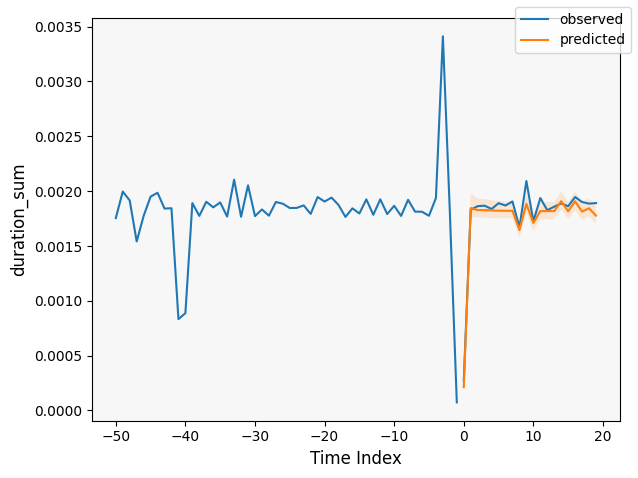

In [91]:
idx=650
fig = best_model.plot_prediction( raw_predictions.x, 
    raw_predictions.output, idx=idx,plot_attention=False
)
ax = fig.axes[0]
# 3) Now customize! For example:
#    – change background
ax.set_facecolor("#f7f7f7")

#    – tweak the legend
# leg = ax.legend(loc="upper left", frameon=True)
# leg.get_frame().set_edgecolor("0.3")
# leg.get_frame().set_linewidth(1.0)



ax.set_xlabel("Time Index", fontsize=12)
ax.set_ylabel("duration_sum", fontsize=12)


plt.tight_layout()
plt.show()

In [14]:
for horizon in horizons:
    print(f"\nTraining TimeXer for horizon={horizon}")
    ckpt_dir = f"checkpoints_timexer_norm/horizon_{horizon}"
    os.makedirs(ckpt_dir, exist_ok=True)

    # build datasets
    training = TimeSeriesDataSet(
        train_df, time_idx="time_idx", group_ids=group_ids, target=target,
        max_encoder_length=max_encoder_length,
        max_prediction_length=horizon,
        static_categoricals=static_categoricals,
        static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=group_ids),
        scalers=covariate_scalers,
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    validation = TimeSeriesDataSet.from_dataset(
        training, val_df, predict=False, stop_randomization=False
    )
    train_loader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_loader   = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    # callbacks
    early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
    checkpoint = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="best-{epoch:02d}-{val_loss:.4f}",
        save_top_k=1,
        monitor="val_loss",
        mode="min",
        verbose=True,
    )
    print_cb = PrintLossCallback(horizon)

    # TimeXer model
    timexer = TimeXer.from_dataset(
        training,
        hidden_size=256,
        n_heads=4,
        e_layers=2,
        d_ff=1024,
        dropout=0.2,
        activation="relu",
        patch_length=5,
        factor=5,
        embed_type="fixed",
        freq="s",
        loss=MeanSquaredError(),
        learning_rate=1e-3,
        logging_metrics=[SMAPE(), MAE(), RMSE(), MAPE()],
        log_interval=10,
        reduce_on_plateau_patience=4,
    )

    # trainer
    trainer = Trainer(callbacks=[early_stop, checkpoint, print_cb], **trainer_kwargs)
    trainer.fit(timexer, train_loader, val_loader)


Training TimeXer for horizon=1


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                   | Params | Mode 
-------------------------------------------------------------------
0 | loss            | TorchMetricWrapper     | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=00  train_loss=0.0000  val_loss=0.0000


Epoch 0, global step 2176: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_timexer_norm/horizon_1/best-epoch=00-val_loss=0.0000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=01  train_loss=0.0000  val_loss=0.0000


Epoch 1, global step 4352: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=02  train_loss=0.0000  val_loss=0.0000


Epoch 2, global step 6528: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=03  train_loss=0.0000  val_loss=0.0000


Epoch 3, global step 8704: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=04  train_loss=0.0000  val_loss=0.0000


Epoch 4, global step 10880: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=05  train_loss=0.0000  val_loss=0.0000


Epoch 5, global step 13056: 'val_loss' was not in top 1



Training TimeXer for horizon=5


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                   | Params | Mode 
-------------------------------------------------------------------
0 | loss            | TorchMetricWrapper     | 0      | train
1 | logging_metrics | ModuleList             | 0      | train
2 | en_embedding    | EnEmbedding            | 1.5 K  | train
3 | ex_embedding    | DataEmbedding_inverted | 13.1 K | train
4 | encoder         | Encoder                | 2.1 M  | train
5 | head            | FlattenHead            | 14.1 K | train
--------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=00  train_loss=0.0000  val_loss=0.0000


Epoch 0, global step 2176: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_timexer_norm/horizon_5/best-epoch=00-val_loss=0.0000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=01  train_loss=0.0000  val_loss=0.0000


Epoch 1, global step 4352: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=02  train_loss=0.0000  val_loss=0.0000


Epoch 2, global step 6528: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=03  train_loss=0.0000  val_loss=0.0000


Epoch 3, global step 8704: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=04  train_loss=0.0000  val_loss=0.0000


Epoch 4, global step 10880: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=05  train_loss=0.0000  val_loss=0.0000


Epoch 5, global step 13056: 'val_loss' was not in top 1



Training TimeXer for horizon=10


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                   | Params | Mode 
-------------------------------------------------------------------
0 | loss            | TorchMetricWrapper     | 0      | train
1 | logging_metrics | ModuleList             | 0      | train
2 | en_embedding    | EnEmbedding            | 1.5 K  | train
3 | ex_embedding    | DataEmbedding_inverted | 13.1 K | train
4 | encoder         | Encoder                | 2.1 M  | train
5 | head            | FlattenHead            | 28.2 K | train
--------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=00  train_loss=0.0000  val_loss=0.0000


Epoch 0, global step 2176: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_timexer_norm/horizon_10/best-epoch=00-val_loss=0.0000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=01  train_loss=0.0000  val_loss=0.0000


Epoch 1, global step 4352: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=02  train_loss=0.0000  val_loss=0.0000


Epoch 2, global step 6528: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=03  train_loss=0.0000  val_loss=0.0000


Epoch 3, global step 8704: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=04  train_loss=0.0000  val_loss=0.0000


Epoch 4, global step 10880: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=05  train_loss=0.0000  val_loss=0.0000


Epoch 5, global step 13056: 'val_loss' was not in top 1



Training TimeXer for horizon=15


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                   | Params | Mode 
-------------------------------------------------------------------
0 | loss            | TorchMetricWrapper     | 0      | train
1 | logging_metrics | ModuleList             | 0      | train
2 | en_embedding    | EnEmbedding            | 1.5 K  | train
3 | ex_embedding    | DataEmbedding_inverted | 13.1 K | train
4 | encoder         | Encoder                | 2.1 M  | train
5 | head            | FlattenHead            | 42.3 K | train
--------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=00  train_loss=0.0000  val_loss=0.0000


Epoch 0, global step 2176: 'val_loss' reached 0.00003 (best 0.00003), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_timexer_norm/horizon_15/best-epoch=00-val_loss=0.0000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=01  train_loss=0.0000  val_loss=0.0000


Epoch 1, global step 4352: 'val_loss' reached 0.00003 (best 0.00003), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_timexer_norm/horizon_15/best-epoch=01-val_loss=0.0000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=02  train_loss=0.0000  val_loss=0.0000


Epoch 2, global step 6528: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=03  train_loss=0.0000  val_loss=0.0000


Epoch 3, global step 8704: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=04  train_loss=0.0000  val_loss=0.0000


Epoch 4, global step 10880: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=05  train_loss=0.0000  val_loss=0.0000


Epoch 5, global step 13056: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=06  train_loss=0.0000  val_loss=0.0000


Epoch 6, global step 15232: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_timexer_norm/horizon_15/best-epoch=06-val_loss=0.0000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=07  train_loss=0.0000  val_loss=0.0000


Epoch 7, global step 17408: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=08  train_loss=0.0000  val_loss=0.0000


Epoch 8, global step 19584: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_timexer_norm/horizon_15/best-epoch=08-val_loss=0.0000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=09  train_loss=0.0000  val_loss=0.0000


Epoch 9, global step 21760: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=10  train_loss=0.0000  val_loss=0.0000


Epoch 10, global step 23936: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=11  train_loss=0.0000  val_loss=0.0000


Epoch 11, global step 26112: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=12  train_loss=0.0000  val_loss=0.0000


Epoch 12, global step 28288: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_timexer_norm/horizon_15/best-epoch=12-val_loss=0.0000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=13  train_loss=0.0000  val_loss=0.0000


Epoch 13, global step 30464: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=14  train_loss=0.0000  val_loss=0.0000


Epoch 14, global step 32640: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=15  train_loss=0.0000  val_loss=0.0000


Epoch 15, global step 34816: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=16  train_loss=0.0000  val_loss=0.0000


Epoch 16, global step 36992: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=17  train_loss=0.0000  val_loss=0.0000


Epoch 17, global step 39168: 'val_loss' was not in top 1



Training TimeXer for horizon=20


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                   | Params | Mode 
-------------------------------------------------------------------
0 | loss            | TorchMetricWrapper     | 0      | train
1 | logging_metrics | ModuleList             | 0      | train
2 | en_embedding    | EnEmbedding            | 1.5 K  | train
3 | ex_embedding    | DataEmbedding_inverted | 13.1 K | train
4 | encoder         | Encoder                | 2.1 M  | train
5 | head            | FlattenHead            | 56.3 K | train
--------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=00  train_loss=0.0000  val_loss=0.0000


Epoch 0, global step 2176: 'val_loss' reached 0.00003 (best 0.00003), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_timexer_norm/horizon_20/best-epoch=00-val_loss=0.0000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=01  train_loss=0.0000  val_loss=0.0000


Epoch 1, global step 4352: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_timexer_norm/horizon_20/best-epoch=01-val_loss=0.0000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=02  train_loss=0.0000  val_loss=0.0000


Epoch 2, global step 6528: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=03  train_loss=0.0000  val_loss=0.0000


Epoch 3, global step 8704: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_timexer_norm/horizon_20/best-epoch=03-val_loss=0.0000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=04  train_loss=0.0000  val_loss=0.0000


Epoch 4, global step 10880: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=05  train_loss=0.0000  val_loss=0.0000


Epoch 5, global step 13056: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=06  train_loss=0.0000  val_loss=0.0000


Epoch 6, global step 15232: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=07  train_loss=0.0000  val_loss=0.0000


Epoch 7, global step 17408: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=08  train_loss=0.0000  val_loss=0.0000


Epoch 8, global step 19584: 'val_loss' was not in top 1


In [16]:
for horizon in horizons:
    print(f"\nEvaluating TimeXer horizon={horizon}")
    ckpt_dir = f"checkpoints_timexer_norm/horizon_{horizon}"
    ckpt_file = [f for f in os.listdir(ckpt_dir) if f.endswith(".ckpt")][0]
    best_ckpt = os.path.join(ckpt_dir, ckpt_file)
    print("Loading:", best_ckpt)

    # rebuild datasets
    training = TimeSeriesDataSet(
        train_df, time_idx="time_idx", group_ids=group_ids, target=target,
        max_encoder_length=max_encoder_length,
        max_prediction_length=horizon,
        static_categoricals=static_categoricals,
        static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=group_ids),
        scalers=covariate_scalers,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    )
    test = TimeSeriesDataSet.from_dataset(
        training, test_df, predict=False, stop_randomization=False
    )
    test_loader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    # load & test
    best_model = TimeXer.load_from_checkpoint(best_ckpt)
    test_results = trainer.test(best_model, dataloaders=test_loader, verbose=False)[0]
    print("Trainer.test metrics:")
    print(f"  test_loss = {test_results['test_loss']:.6f}")
    print(f"  test_SMAPE= {test_results['test_SMAPE']:.6f}")
    print(f"  test_MAE=   {test_results['test_MAE']:.6f}")
    print(f"  test_RMSE=  {test_results['test_RMSE']:.6f}")
    print(f"  test_MAPE=  {test_results['test_MAPE']:.6f}")

    # manual forecasts
    raw = best_model.predict(test_loader)
    preds = raw.detach().cpu().numpy() if isinstance(raw, torch.Tensor) else raw
    # flatten (single‐output model)
    y_pred = preds.flatten()

    # true values
    y_true = np.concatenate(
        [y.detach().cpu().numpy() for _, (y, _) in iter(test_loader)],
        axis=0
    ).flatten()

    # manual metrics
    mse   = mean_squared_error(y_true, y_pred)
    rmse  = np.sqrt(mse)
    mae   = mean_absolute_error(y_true, y_pred)
    mape  = mean_absolute_percentage_error(y_true, y_pred)
    smape = 100 * np.mean(
        2 * np.abs(y_pred - y_true) /
        (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

    print("Manual metrics on point forecasts:")
    print(f"  MSE=   {mse:.6f}")
    print(f"  RMSE=  {rmse:.6f}")
    print(f"  MAE=   {mae:.6f}")
    print(f"  MAPE=  {mape:.2%}")
    print(f"  SMAPE= {smape:.6f}%")


Evaluating TimeXer horizon=1
Loading: checkpoints_timexer_norm/horizon_1/best-epoch=00-val_loss=0.0000.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trainer.test metrics:
  test_loss = 0.000038
  test_SMAPE= 0.246536
  test_MAE=   0.002344
  test_RMSE=  0.003853
  test_MAPE=  0.635701


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Manual metrics on point forecasts:
  MSE=   0.000038
  RMSE=  0.006176
  MAE=   0.002344
  MAPE=  63.57%
  SMAPE= 24.653566%

Evaluating TimeXer horizon=5
Loading: checkpoints_timexer_norm/horizon_5/best-epoch=00-val_loss=0.0000.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trainer.test metrics:
  test_loss = 0.000043
  test_SMAPE= 0.206918
  test_MAE=   0.002194
  test_RMSE=  0.004152
  test_MAPE=  0.496143


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Manual metrics on point forecasts:
  MSE=   0.000043
  RMSE=  0.006556
  MAE=   0.002194
  MAPE=  49.62%
  SMAPE= 20.691841%

Evaluating TimeXer horizon=10
Loading: checkpoints_timexer_norm/horizon_10/best-epoch=00-val_loss=0.0000.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trainer.test metrics:
  test_loss = 0.000042
  test_SMAPE= 0.213822
  test_MAE=   0.002145
  test_RMSE=  0.003926
  test_MAPE=  0.541095


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Manual metrics on point forecasts:
  MSE=   0.000042
  RMSE=  0.006498
  MAE=   0.002145
  MAPE=  54.11%
  SMAPE= 21.382158%

Evaluating TimeXer horizon=15
Loading: checkpoints_timexer_norm/horizon_15/best-epoch=12-val_loss=0.0000.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trainer.test metrics:
  test_loss = 0.000045
  test_SMAPE= 0.213262
  test_MAE=   0.002287
  test_RMSE=  0.004327
  test_MAPE=  0.593747


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Manual metrics on point forecasts:
  MSE=   0.000045
  RMSE=  0.006731
  MAE=   0.002287
  MAPE=  59.38%
  SMAPE= 21.326199%

Evaluating TimeXer horizon=20
Loading: checkpoints_timexer_norm/horizon_20/best-epoch=03-val_loss=0.0000.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trainer.test metrics:
  test_loss = 0.000045
  test_SMAPE= 0.226566
  test_MAE=   0.002305
  test_RMSE=  0.004205
  test_MAPE=  0.654264


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Manual metrics on point forecasts:
  MSE=   0.000045
  RMSE=  0.006706
  MAE=   0.002305
  MAPE=  65.43%
  SMAPE= 22.656595%


In [17]:
for horizon in horizons:
    print(f"\nTraining TiDEModel for horizon={horizon}")
    ckpt_dir = f"checkpoints_tide/horizon_{horizon}"
    os.makedirs(ckpt_dir, exist_ok=True)

    # build datasets
    training = TimeSeriesDataSet(
        train_df, time_idx="time_idx", group_ids=group_ids, target=target,
        max_encoder_length=max_encoder_length,
        max_prediction_length=horizon,
        static_categoricals=static_categoricals,
        static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=group_ids),
        add_relative_time_idx=False,
        add_target_scales=True,
        add_encoder_length=True,
    )
    validation = TimeSeriesDataSet.from_dataset(
        training, val_df, predict=False, stop_randomization=False
    )
    train_loader = training.to_dataloader(train=True,  batch_size=batch_size, num_workers=0)
    val_loader   = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    # callbacks
    early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
    checkpoint = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="best-{epoch:02d}-{val_loss:.4f}",
        save_top_k=1,
        monitor="val_loss",
        mode="min",
        verbose=True,
    )
    print_cb = PrintLossCallback(horizon)

    # create TiDEModel
    tide = TiDEModel.from_dataset(
        training,
        input_chunk_length=max_encoder_length,
        output_chunk_length=horizon,
        num_encoder_layers=2,
        num_decoder_layers=2,
        decoder_output_dim=16,
        hidden_size=128,
        temporal_width_future=4,
        temporal_hidden_size_future=32,
        temporal_decoder_hidden=32,
        use_layer_norm=False,
        dropout=0.1,
        # quantile‐forecasting head:
        loss = MeanSquaredError(),
        
        logging_metrics=[SMAPE(), MAE(), RMSE(), MAPE()],
        learning_rate=1e-3,
    )

    # trainer & fit
    trainer = Trainer(callbacks=[early_stop, checkpoint, print_cb], **trainer_kwargs)
    trainer.fit(tide, train_loader, val_loader)



Training TiDEModel for horizon=1


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | _TideModule        | 203 K  | train
---------------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.814     Total estimated mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 2176: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_1/best-epoch=00-val_loss=0.0000.ckpt' as top 1


Horizon=1  Epoch=00  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 4352: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_1/best-epoch=01-val_loss=0.0000.ckpt' as top 1


Horizon=1  Epoch=01  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 6528: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_1/best-epoch=02-val_loss=0.0000.ckpt' as top 1


Horizon=1  Epoch=02  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 8704: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_1/best-epoch=03-val_loss=0.0000.ckpt' as top 1


Horizon=1  Epoch=03  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 10880: 'val_loss' was not in top 1


Horizon=1  Epoch=04  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 13056: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_1/best-epoch=05-val_loss=0.0000.ckpt' as top 1


Horizon=1  Epoch=05  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 15232: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_1/best-epoch=06-val_loss=0.0000.ckpt' as top 1


Horizon=1  Epoch=06  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 17408: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_1/best-epoch=07-val_loss=0.0000.ckpt' as top 1


Horizon=1  Epoch=07  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 19584: 'val_loss' was not in top 1


Horizon=1  Epoch=08  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 21760: 'val_loss' was not in top 1


Horizon=1  Epoch=09  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 23936: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_1/best-epoch=10-val_loss=0.0000.ckpt' as top 1


Horizon=1  Epoch=10  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 26112: 'val_loss' was not in top 1


Horizon=1  Epoch=11  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 28288: 'val_loss' was not in top 1


Horizon=1  Epoch=12  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 30464: 'val_loss' was not in top 1


Horizon=1  Epoch=13  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 32640: 'val_loss' was not in top 1


Horizon=1  Epoch=14  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 34816: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_1/best-epoch=15-val_loss=0.0000.ckpt' as top 1


Horizon=1  Epoch=15  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 36992: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_1/best-epoch=16-val_loss=0.0000.ckpt' as top 1


Horizon=1  Epoch=16  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 39168: 'val_loss' was not in top 1


Horizon=1  Epoch=17  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 41344: 'val_loss' was not in top 1


Horizon=1  Epoch=18  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 43520: 'val_loss' was not in top 1


Horizon=1  Epoch=19  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 45696: 'val_loss' was not in top 1


Horizon=1  Epoch=20  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 47872: 'val_loss' was not in top 1


Horizon=1  Epoch=21  train_loss=0.0000  val_loss=0.0000

Training TiDEModel for horizon=5


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | _TideModule        | 224 K  | train
---------------------------------------------------------------
224 K     Trainable params
0         Non-trainable params
224 K     Total params
0.898     Total estimated mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 2176: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_5/best-epoch=00-val_loss=0.0000.ckpt' as top 1


Horizon=5  Epoch=00  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 4352: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_5/best-epoch=01-val_loss=0.0000.ckpt' as top 1


Horizon=5  Epoch=01  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 6528: 'val_loss' was not in top 1


Horizon=5  Epoch=02  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 8704: 'val_loss' was not in top 1


Horizon=5  Epoch=03  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 10880: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_5/best-epoch=04-val_loss=0.0000.ckpt' as top 1


Horizon=5  Epoch=04  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 13056: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_5/best-epoch=05-val_loss=0.0000.ckpt' as top 1


Horizon=5  Epoch=05  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 15232: 'val_loss' was not in top 1


Horizon=5  Epoch=06  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 17408: 'val_loss' was not in top 1


Horizon=5  Epoch=07  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 19584: 'val_loss' was not in top 1


Horizon=5  Epoch=08  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 21760: 'val_loss' was not in top 1


Horizon=5  Epoch=09  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 23936: 'val_loss' was not in top 1


Horizon=5  Epoch=10  train_loss=0.0000  val_loss=0.0000

Training TiDEModel for horizon=10


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | _TideModule        | 250 K  | train
---------------------------------------------------------------
250 K     Trainable params
0         Non-trainable params
250 K     Total params
1.002     Total estimated mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 2176: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_10/best-epoch=00-val_loss=0.0000.ckpt' as top 1


Horizon=10  Epoch=00  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 4352: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_10/best-epoch=01-val_loss=0.0000.ckpt' as top 1


Horizon=10  Epoch=01  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 6528: 'val_loss' was not in top 1


Horizon=10  Epoch=02  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 8704: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_10/best-epoch=03-val_loss=0.0000.ckpt' as top 1


Horizon=10  Epoch=03  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 10880: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_10/best-epoch=04-val_loss=0.0000.ckpt' as top 1


Horizon=10  Epoch=04  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 13056: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_10/best-epoch=05-val_loss=0.0000.ckpt' as top 1


Horizon=10  Epoch=05  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 15232: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_10/best-epoch=06-val_loss=0.0000.ckpt' as top 1


Horizon=10  Epoch=06  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 17408: 'val_loss' was not in top 1


Horizon=10  Epoch=07  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 19584: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_10/best-epoch=08-val_loss=0.0000.ckpt' as top 1


Horizon=10  Epoch=08  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 21760: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_10/best-epoch=09-val_loss=0.0000.ckpt' as top 1


Horizon=10  Epoch=09  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 23936: 'val_loss' was not in top 1


Horizon=10  Epoch=10  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 26112: 'val_loss' was not in top 1


Horizon=10  Epoch=11  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 28288: 'val_loss' was not in top 1


Horizon=10  Epoch=12  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 30464: 'val_loss' was not in top 1


Horizon=10  Epoch=13  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 32640: 'val_loss' was not in top 1


Horizon=10  Epoch=14  train_loss=0.0000  val_loss=0.0000

Training TiDEModel for horizon=15


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | _TideModule        | 276 K  | train
---------------------------------------------------------------
276 K     Trainable params
0         Non-trainable params
276 K     Total params
1.106     Total estimated mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 2176: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_15/best-epoch=00-val_loss=0.0000.ckpt' as top 1


Horizon=15  Epoch=00  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 4352: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_15/best-epoch=01-val_loss=0.0000.ckpt' as top 1


Horizon=15  Epoch=01  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 6528: 'val_loss' was not in top 1


Horizon=15  Epoch=02  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 8704: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_15/best-epoch=03-val_loss=0.0000.ckpt' as top 1


Horizon=15  Epoch=03  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 10880: 'val_loss' was not in top 1


Horizon=15  Epoch=04  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 13056: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_15/best-epoch=05-val_loss=0.0000.ckpt' as top 1


Horizon=15  Epoch=05  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 15232: 'val_loss' was not in top 1


Horizon=15  Epoch=06  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 17408: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_15/best-epoch=07-val_loss=0.0000.ckpt' as top 1


Horizon=15  Epoch=07  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 19584: 'val_loss' was not in top 1


Horizon=15  Epoch=08  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 21760: 'val_loss' was not in top 1


Horizon=15  Epoch=09  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 23936: 'val_loss' was not in top 1


Horizon=15  Epoch=10  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 26112: 'val_loss' was not in top 1


Horizon=15  Epoch=11  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 28288: 'val_loss' was not in top 1


Horizon=15  Epoch=12  train_loss=0.0000  val_loss=0.0000

Training TiDEModel for horizon=20


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | loss            | TorchMetricWrapper | 0      | train
1 | logging_metrics | ModuleList         | 0      | train
2 | embeddings      | MultiEmbedding     | 0      | train
3 | model           | _TideModule        | 302 K  | train
---------------------------------------------------------------
302 K     Trainable params
0         Non-trainable params
302 K     Total params
1.210     Total estimated mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 2176: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_20/best-epoch=00-val_loss=0.0000.ckpt' as top 1


Horizon=20  Epoch=00  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 4352: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_20/best-epoch=01-val_loss=0.0000.ckpt' as top 1


Horizon=20  Epoch=01  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 6528: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_20/best-epoch=02-val_loss=0.0000.ckpt' as top 1


Horizon=20  Epoch=02  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 8704: 'val_loss' reached 0.00001 (best 0.00001), saving model to '/home/unt.ad.unt.edu/srr0248/Desktop/pytorch_for/pytorch-forecasting/examples/checkpoints_tide/horizon_20/best-epoch=03-val_loss=0.0000.ckpt' as top 1


Horizon=20  Epoch=03  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 10880: 'val_loss' was not in top 1


Horizon=20  Epoch=04  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 13056: 'val_loss' was not in top 1


Horizon=20  Epoch=05  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 15232: 'val_loss' was not in top 1


Horizon=20  Epoch=06  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 17408: 'val_loss' was not in top 1


Horizon=20  Epoch=07  train_loss=0.0000  val_loss=0.0000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 19584: 'val_loss' was not in top 1


Horizon=20  Epoch=08  train_loss=0.0000  val_loss=0.0000


In [19]:
for horizon in horizons:
    print(f"\nEvaluating TiDEModel horizon={horizon}")
    ckpt_dir = f"checkpoints_tide/horizon_{horizon}"
    ckpt_file = next(f for f in os.listdir(ckpt_dir) if f.endswith(".ckpt"))
    best_ckpt = os.path.join(ckpt_dir, ckpt_file)
    print("Loading:", best_ckpt)

    # rebuild datasets
    training = TimeSeriesDataSet(
        train_df, time_idx="time_idx", group_ids=group_ids, target=target,
        max_encoder_length=max_encoder_length,
        max_prediction_length=horizon,
        static_categoricals=static_categoricals,
        static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=group_ids),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )
    test = TimeSeriesDataSet.from_dataset(
        training, test_df, predict=False, stop_randomization=False
    )
    test_loader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    # load & test
    best_model = TiDEModel.load_from_checkpoint(best_ckpt)
    test_results = trainer.test(best_model, dataloaders=test_loader, verbose=False)[0]
    print("Trainer.test metrics:")
    print(f"  test_loss = {test_results['test_loss']:.6f}")
    print(f"  test_SMAPE= {test_results['test_SMAPE']:.6f}")
    print(f"  test_MAE=   {test_results['test_MAE']:.6f}")
    print(f"  test_RMSE=  {test_results['test_RMSE']:.6f}")
    print(f"  test_MAPE=  {test_results['test_MAPE']:.6f}")

    # manual on median forecasts
    raw = best_model.predict(test_loader).detach().cpu().numpy()
    median = raw.flatten()  # (n_windows,horizon,3) → 0.5-quantile
    actuals = np.concatenate(
        [y.detach().cpu().numpy() for _, (y, _) in iter(test_loader)],
        axis=0
    ).flatten()

    mse   = mean_squared_error(actuals, median)
    rmse  = np.sqrt(mse)
    mae   = mean_absolute_error(actuals, median)
    mape  = mean_absolute_percentage_error(actuals, median)
    smape = 100 * np.mean(
        2 * np.abs(median - actuals) /
        (np.abs(actuals) + np.abs(median) + 1e-8)
    )
    print("Manual metrics on median forecasts:")
    print(f"  MSE=   {mse:.6f}")
    print(f"  RMSE=  {rmse:.6f}")
    print(f"  MAE=   {mae:.6f}")
    print(f"  MAPE=  {mape:.2%}")
    print(f"  SMAPE= {smape:.6f}%")


Evaluating TiDEModel horizon=1
Loading: checkpoints_tide/horizon_1/best-epoch=16-val_loss=0.0000.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trainer.test metrics:
  test_loss = 0.000085
  test_SMAPE= 0.333293
  test_MAE=   0.003945
  test_RMSE=  0.007608
  test_MAPE=  1.196059


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Manual metrics on median forecasts:
  MSE=   0.000085
  RMSE=  0.009222
  MAE=   0.003945
  MAPE=  119.61%
  SMAPE= 33.329296%

Evaluating TiDEModel horizon=5
Loading: checkpoints_tide/horizon_5/best-epoch=05-val_loss=0.0000.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trainer.test metrics:
  test_loss = 0.000063
  test_SMAPE= 0.332303
  test_MAE=   0.003275
  test_RMSE=  0.005899
  test_MAPE=  0.918928


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Manual metrics on median forecasts:
  MSE=   0.000063
  RMSE=  0.007916
  MAE=   0.003275
  MAPE=  91.90%
  SMAPE= 33.230267%

Evaluating TiDEModel horizon=10
Loading: checkpoints_tide/horizon_10/best-epoch=09-val_loss=0.0000.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trainer.test metrics:
  test_loss = 0.000058
  test_SMAPE= 0.430315
  test_MAE=   0.003584
  test_RMSE=  0.005473
  test_MAPE=  1.087117


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Manual metrics on median forecasts:
  MSE=   0.000058
  RMSE=  0.007625
  MAE=   0.003584
  MAPE=  108.72%
  SMAPE= 43.031509%

Evaluating TiDEModel horizon=15
Loading: checkpoints_tide/horizon_15/best-epoch=07-val_loss=0.0000.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trainer.test metrics:
  test_loss = 0.000051
  test_SMAPE= 0.373532
  test_MAE=   0.003111
  test_RMSE=  0.004704
  test_MAPE=  0.815625


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Manual metrics on median forecasts:
  MSE=   0.000051
  RMSE=  0.007118
  MAE=   0.003111
  MAPE=  81.57%
  SMAPE= 37.353168%

Evaluating TiDEModel horizon=20
Loading: checkpoints_tide/horizon_20/best-epoch=03-val_loss=0.0000.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trainer.test metrics:
  test_loss = 0.000054
  test_SMAPE= 0.408554
  test_MAE=   0.003392
  test_RMSE=  0.004957
  test_MAPE=  0.529119


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Manual metrics on median forecasts:
  MSE=   0.000054
  RMSE=  0.007333
  MAE=   0.003392
  MAPE=  52.91%
  SMAPE= 40.855362%


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

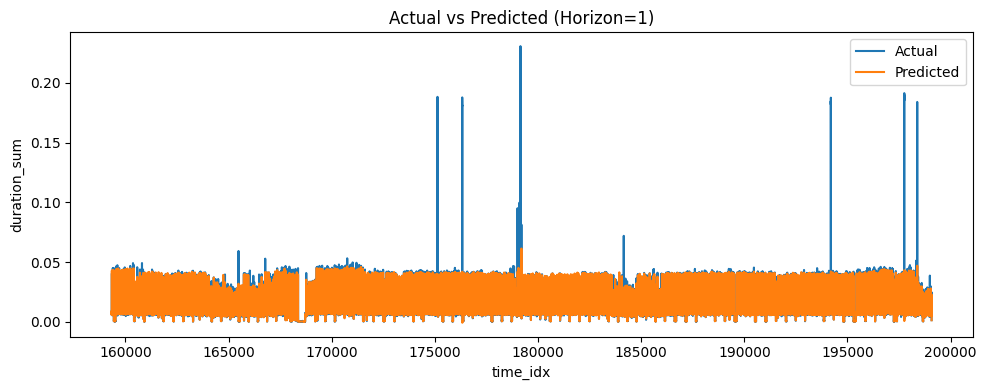

In [13]:
horizon = 1
# rebuild dataset and loader as before
training = TimeSeriesDataSet(
    train_df, time_idx="time_idx", group_ids=group_ids, target=target,
    max_encoder_length=max_encoder_length, max_prediction_length=horizon,
    static_categoricals=static_categoricals, static_reals=static_reals,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals=time_varying_unknown_reals,
    target_normalizer=GroupNormalizer(groups=group_ids),
    add_relative_time_idx=True, add_target_scales=True, add_encoder_length=True,
)
test = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=False)
test_loader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

best_ckpt = "checkpoints/horizon_1/" + os.listdir("checkpoints/horizon_1")[0]
model = TemporalFusionTransformer.load_from_checkpoint(best_ckpt)

# get forecasts & true values
preds = model.predict(test_loader).detach().cpu().numpy().flatten()
actuals = np.concatenate([y.detach().cpu().numpy() for _, (y, _) in iter(test_loader)], axis=0).flatten()

# build timestamp axis
timestamps = test_df['time_idx'].iloc[max_encoder_length:].reset_index(drop=True)

# plot
plt.figure(figsize=(10,4))
plt.plot(timestamps, actuals, label='Actual')
plt.plot(timestamps, preds, label='Predicted')
plt.xlabel('time_idx')
plt.ylabel('duration_sum')
plt.title('Actual vs Predicted (Horizon=1)')
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
for horizon in [1, 5, 10, 15, 20]:
    print(f"\n▶ Training N-HiTS for horizon={horizon}")
    ckpt_dir = f"ckpts_nhits/horizon_{horizon}"
    os.makedirs(ckpt_dir, exist_ok=True)

    # dataset / dataloaders
    training = TimeSeriesDataSet(
        train_df, time_idx="time_idx", group_ids=group_ids, target=target,
        max_encoder_length=max_encoder_length, max_prediction_length=horizon,
        static_categoricals=static_categoricals, static_reals=static_reals,
        time_varying_known_reals=time_varying_known_reals,
        time_varying_unknown_reals=time_varying_unknown_reals,
        target_normalizer=GroupNormalizer(groups=group_ids),
        scalers=covariate_scalers,
        add_relative_time_idx=False,
        add_target_scales=True,
        add_encoder_length=True,
    )
    validation = TimeSeriesDataSet.from_dataset(
        training, val_df, predict=False, stop_randomization=False
    )
    train_loader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_loader   = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    # callbacks
    early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
    checkpoint = ModelCheckpoint(
        dirpath=ckpt_dir,
        filename="best-{epoch:02d}-{val_loss:.4f}",
        save_top_k=1,
        monitor="val_loss",
        mode="min",
    )
    print_cb = PrintLossCallback(horizon)

    # instantiate N-HiTS
    nhits = NHiTS.from_dataset(
        training,
        hidden_size=128,
        static_hidden_size=128,
        dropout=0.1,
        n_blocks=[1, 1, 1],           # default stack depths
        n_layers=2,                   # 2 layers per block
        shared_weights=True,
        naive_level=True,
        initialization="lecun_normal",
        learning_rate=1e-3,
        context_length=max_encoder_length,
        prediction_length=horizon,
        loss=QuantileLoss(quantiles=[0.1, 0.5, 0.9]),
        output_size=3,                # match three quantiles
        logging_metrics=[SMAPE(), MAE(), RMSE(), MAPE()],
        reduce_on_plateau_patience=4,
    )

    trainer = Trainer(
        max_epochs=epochs,
        accelerator="gpu",
        devices=1,
        gradient_clip_val=0.1,
        callbacks=[early_stop, checkpoint, print_cb],
    )
    trainer.fit(nhits, train_loader, val_loader)


▶ Training N-HiTS for horizon=1


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | QuantileLoss   | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 336 K  | train
-----------------------------------------------------------
336 K     Trainable params
0         Non-trainable params
336 K     Total params
1.345     Total estimated model params size (MB)
58      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=00  train_loss=0.0014  val_loss=0.0015


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=01  train_loss=0.0014  val_loss=0.0016


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=02  train_loss=0.0014  val_loss=0.0016


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=03  train_loss=0.0014  val_loss=0.0016


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=04  train_loss=0.0014  val_loss=0.0016


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=1  Epoch=05  train_loss=0.0014  val_loss=0.0016

▶ Training N-HiTS for horizon=5


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | QuantileLoss   | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 347 K  | train
-----------------------------------------------------------
347 K     Trainable params
0         Non-trainable params
347 K     Total params
1.390     Total estimated model params size (MB)
58      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=00  train_loss=0.0017  val_loss=0.0020


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=01  train_loss=0.0017  val_loss=0.0019


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=02  train_loss=0.0017  val_loss=0.0021


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=03  train_loss=0.0017  val_loss=0.0020


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=04  train_loss=0.0017  val_loss=0.0020


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=05  train_loss=0.0017  val_loss=0.0019


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=06  train_loss=0.0017  val_loss=0.0020


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=07  train_loss=0.0017  val_loss=0.0020


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=08  train_loss=0.0017  val_loss=0.0019


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=09  train_loss=0.0017  val_loss=0.0019


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=5  Epoch=10  train_loss=0.0017  val_loss=0.0020

▶ Training N-HiTS for horizon=10


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | QuantileLoss   | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 367 K  | train
-----------------------------------------------------------
367 K     Trainable params
0         Non-trainable params
367 K     Total params
1.471     Total estimated model params size (MB)
58      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=00  train_loss=0.0024  val_loss=0.0029


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=01  train_loss=0.0024  val_loss=0.0029


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=02  train_loss=0.0024  val_loss=0.0028


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=03  train_loss=0.0024  val_loss=0.0029


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=04  train_loss=0.0024  val_loss=0.0028


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=05  train_loss=0.0024  val_loss=0.0029


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=06  train_loss=0.0024  val_loss=0.0028


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=07  train_loss=0.0024  val_loss=0.0029


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=08  train_loss=0.0024  val_loss=0.0028


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=09  train_loss=0.0024  val_loss=0.0028


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=10  train_loss=0.0024  val_loss=0.0030


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=11  train_loss=0.0024  val_loss=0.0028


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=12  train_loss=0.0024  val_loss=0.0028


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=13  train_loss=0.0024  val_loss=0.0029


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=10  Epoch=14  train_loss=0.0024  val_loss=0.0029

▶ Training N-HiTS for horizon=15


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | QuantileLoss   | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 385 K  | train
-----------------------------------------------------------
385 K     Trainable params
0         Non-trainable params
385 K     Total params
1.540     Total estimated model params size (MB)
58      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=00  train_loss=0.0027  val_loss=0.0032


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=01  train_loss=0.0027  val_loss=0.0031


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=02  train_loss=0.0027  val_loss=0.0032


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=03  train_loss=0.0027  val_loss=0.0032


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=04  train_loss=0.0027  val_loss=0.0032


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=05  train_loss=0.0027  val_loss=0.0031


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=15  Epoch=06  train_loss=0.0027  val_loss=0.0032

▶ Training N-HiTS for horizon=20


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | QuantileLoss   | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 406 K  | train
-----------------------------------------------------------
406 K     Trainable params
0         Non-trainable params
406 K     Total params
1.626     Total estimated model params size (MB)
58      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=00  train_loss=0.0029  val_loss=0.0035


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=01  train_loss=0.0029  val_loss=0.0033


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=02  train_loss=0.0029  val_loss=0.0034


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=03  train_loss=0.0029  val_loss=0.0034


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=04  train_loss=0.0029  val_loss=0.0033


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=05  train_loss=0.0029  val_loss=0.0034


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=06  train_loss=0.0029  val_loss=0.0033


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=07  train_loss=0.0029  val_loss=0.0034


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=08  train_loss=0.0029  val_loss=0.0033


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=09  train_loss=0.0029  val_loss=0.0035


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=10  train_loss=0.0029  val_loss=0.0036


Validation: |          | 0/? [00:00<?, ?it/s]

Horizon=20  Epoch=11  train_loss=0.0029  val_loss=0.0034


In [65]:
for horizon in [1, 5, 10, 15, 20]:
    print(f"\n▶ Evaluating N-HiTS for horizon={horizon}")
    ckpt_dir = f"ckpts_nhits/horizon_{horizon}"
    ckpt_files = [f for f in os.listdir(ckpt_dir) if f.endswith(".ckpt")]
    assert len(ckpt_files) == 1, "Expected one checkpoint per horizon"
    best_ckpt = os.path.join(ckpt_dir, ckpt_files[0])
    print(f"Loading {best_ckpt}")

    # rebuild test loader
    training = TimeSeriesDataSet.from_dataset(
        TimeSeriesDataSet(
            train_df, time_idx="time_idx", group_ids=group_ids, target=target,
            max_encoder_length=max_encoder_length, max_prediction_length=horizon,
            static_categoricals=static_categoricals, static_reals=static_reals,
            time_varying_known_reals=time_varying_known_reals,
            time_varying_unknown_reals=time_varying_unknown_reals,
            target_normalizer=GroupNormalizer(groups=group_ids),
            scalers=covariate_scalers,
            add_relative_time_idx=False,
            add_target_scales=True,
            add_encoder_length=True,
        ),
        test_df, predict=False, stop_randomization=False
    )
    test_loader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

    # load & test
    best_model = NHiTS.load_from_checkpoint(best_ckpt)
    _ = Trainer(accelerator="gpu", devices=1).test(best_model, dataloaders=test_loader)

    # predict & compute point‐forecast metrics on median
    preds_q = best_model.predict(test_loader).detach().cpu().numpy()
    median = preds_q.flatten()  # index 1 → 0.5 quantile

    actuals = np.concatenate(
        [y.detach().cpu().numpy() for _, (y, _) in iter(test_loader)],
        axis=0
    ).flatten()

    mse   = mean_squared_error(actuals, median)
    rmse  = np.sqrt(mse)
    mae   = mean_absolute_error(actuals, median)
    mape  = mean_absolute_percentage_error(actuals, median)
    smape = 100 * np.mean(
        2 * np.abs(median - actuals) /
        (np.abs(actuals) + np.abs(median) + 1e-8)
    )

    print(
        f"Horizon {horizon}: "
        f"MSE={mse:.6f}, RMSE={rmse:.6f}, "
        f"MAE={mae:.6f}, MAPE={mape:.6%}, SMAPE={smape:.4f}%"
    )


▶ Evaluating N-HiTS for horizon=1
Loading ckpts_nhits/horizon_1/best-epoch=00-val_loss=0.0015.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE           0.001981701236218214
        test_MAPE           0.2666403353214264
        test_RMSE          0.005256015807390213
       test_SMAPE           0.1450660228729248
        test_loss          0.0016025870572775602
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Horizon 1: MSE=0.000035, RMSE=0.005880, MAE=0.001982, MAPE=26.664731%, SMAPE=14.5066%

▶ Evaluating N-HiTS for horizon=5
Loading ckpts_nhits/horizon_5/best-epoch=05-val_loss=0.0019.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE           0.0028865933418273926
        test_MAPE           0.47074800729751587
        test_RMSE          0.006187786348164082
       test_SMAPE           0.23454247415065765
        test_loss          0.0019593569450080395
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Horizon 5: MSE=0.000053, RMSE=0.007305, MAE=0.002887, MAPE=47.075871%, SMAPE=23.4542%

▶ Evaluating N-HiTS for horizon=10
Loading ckpts_nhits/horizon_10/best-epoch=09-val_loss=0.0028.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE           0.004594553727656603
        test_MAPE           0.6674462556838989
        test_RMSE          0.008557007648050785
       test_SMAPE           0.34072163701057434
        test_loss          0.0028342283330857754
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Horizon 10: MSE=0.000099, RMSE=0.009939, MAE=0.004595, MAPE=66.745949%, SMAPE=34.0722%

▶ Evaluating N-HiTS for horizon=15
Loading ckpts_nhits/horizon_15/best-epoch=01-val_loss=0.0031.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE           0.004926137626171112
        test_MAPE            0.560456395149231
        test_RMSE          0.010214126668870449
       test_SMAPE           0.3749484717845917
        test_loss          0.0031718898098915815
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Horizon 15: MSE=0.000135, RMSE=0.011628, MAE=0.004926, MAPE=56.046605%, SMAPE=37.4948%

▶ Evaluating N-HiTS for horizon=20
Loading ckpts_nhits/horizon_20/best-epoch=06-val_loss=0.0033.ckpt


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DE

Testing: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE           0.004995570983737707
        test_MAPE           0.5788699388504028
        test_RMSE          0.010280168615281582
       test_SMAPE           0.3900076150894165
        test_loss          0.003475490491837263
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/unt.ad.unt.edu/srr0248/.conda/envs/pytorch-forecasting-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Horizon 20: MSE=0.000138, RMSE=0.011743, MAE=0.004996, MAPE=57.887971%, SMAPE=39.0008%
